<a href="https://colab.research.google.com/github/abiolakunle/ANE_Ecommerce/blob/master/chris_supply_chain_simpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

In [ ]:
import simpy
import random
import matplotlib.pyplot as plt

# Define the widgets with their properties
# check-reorder (in Warehouse) - supports auto reorders (reorder level of -1 means reordering is never done)
# reorder duration is how long a reorder is expected to take
# the list is_made_of contains the widget_types that are used to create the owning widget.

class Widget:
    def __init__(self, widget_type, reorder_level, price, reorder_duration, reorder_amount, size):
        self.widget_type = widget_type
        self.reorder_level = reorder_level
        self.price = price
        self.reorder_duration = reorder_duration
        self.reorder_amount = reorder_amount
        self.size = size
        self.is_made_of = []

# Define the warehouse (this is a generic warehouse model, capable of holding widgets)
# The key feature of it is that it can store and retreive widgets, and there is a method
# can_accept to check capacity.
# check-reorder - auto reorders stock with a reorder limit set. (reorder limit of -1 means reordering is never done)
# for the checking of reorder we also hold information on which widgets are onorder
class Warehouse(simpy.Store):
    def __init__(self, env, name, capacity):
        self.env = env  # SimPy environment
        self.name = name
        self.capacity = capacity  # Maximum warehouse capacity
        self.inventory = {}  # Inventory dictionary to keep track of widget quantities
        self.knowledgeof = [] # The widgets that the warehous is able to track
        self.onorder = [] # The widget names on order
        self.log = {  # Log dictionary to keep track of events for plotting
            'space_used': []
        }

    def space_used(self): # Space currently used in the warehouse
        res = 0
        for w in self.knowledgeof:
          res =+ self.inventory[w.widget_type] * w.size
        return res

    def addNewProduct(self, widget, level=0):
        if not(widget.widget_type in self.inventory.keys()):
          self.inventory[widget.widget_type] = level
          self.knowledgeof.append(widget)
          self.log[widget.widget_type]=[(self.env.now, 'store', level)]

    def can_accept(self, space_needed):
      print(f'In {self.name}: {self.space_used()} as well as {space_needed} less {self.capacity}')
      return (self.space_used() + space_needed) <= self.capacity

    # Method to store widgets in the warehouse
    def store(self, widget, quantity):
        space_needed = widget.size * quantity
        if self.can_accept(space_needed):
            if  widget.widget_type in self.onorder:
              self.onorder.remove(widget.widget_type)
            self.inventory[widget.widget_type] += quantity
            self.log[widget.widget_type].append((self.env.now, 'store', self.inventory[widget.widget_type]))
            self.log['space_used'].append((self.env.now, self.space_used()))
            print(f'Warehouse {self.name}, received {quantity} {widget.widget_type}s ({self.inventory[widget.widget_type]} in stock, onorder {self.onorder})')
        else:
            self.log[widget.widget_type].append((self.env.now, 'store', self.inventory[widget.widget_type]))
            self.log['space_used'].append((self.env.now, self.space_used()))
            print("Warehouse overloaded:", self.name)
            # self.env.overflow.succeed()

    # Method to retrieve widgets from the warehouse
    def retrieve(self, widget, quantity):
        if (self.inventory[widget.widget_type] >= quantity):
          self.inventory[widget.widget_type] -= quantity
          self.log[widget.widget_type].append((self.env.now, 'retrieve', self.inventory[widget.widget_type]))
          self.log['space_used'].append((self.env.now, self.space_used()))
          self.check_reorder(widget)
          print(f'Warehouse {self.name}, taken {quantity} {widget.widget_type}s ({self.inventory[widget.widget_type]} left, onorder {self.onorder})')
        else:
          print("Warehouse underloaded:", self.name)


    # Method to check if reordering is needed and initiate reorder process
    def check_reorder(self, widget):
      print(f'{widget.widget_type} check-reorder {widget.reorder_level} and {self.onorder} and {self.can_accept(widget.reorder_amount * widget.size)}')
      if ((self.inventory[widget.widget_type] <= widget.reorder_level) and
      not (widget.widget_type in self.onorder) and
      self.can_accept(widget.reorder_amount * widget.size)):
          print(f'Reordering {widget.reorder_amount} of {widget.widget_type} at time {self.env.now} for warehouse {self.name}')
          self.log[widget.widget_type].append((self.env.now, 'reorder', widget.reorder_amount))
          self.onorder.append(widget.widget_type)
          env.process(self.env.supplier.supply(widget, widget.reorder_amount))

# Define the supplier
class Supplier:
    def __init__(self, env, warehouse):
        self.env = env  # SimPy environment
        self.warehouse = warehouse  # Reference to the warehouse

    # Method to supply widgets to the warehouse
    def supply(self, widget, quantity):
        yield self.env.timeout(widget.reorder_duration)  # Simulate supply delay
        self.warehouse.store(widget, quantity)
        print(f'Supplied {quantity} of {widget.widget_type} at time {self.env.now} to warehouse {self.warehouse.name}')

# Define the maker
class Maker:
    def __init__(self, env, warehouseIn, warehouseOut):
        self.env = env  # SimPy environment
        self.warehouseIn = warehouseIn  # Reference to the warehouse where raw materials are stored and products are stored
        self.warehouseOut = warehouseOut

    # Method to produce Widget C using Widget A and Widget B
    def produce(self, widget_a, widget_b, widget_c):
        while True:  # Infinite loop to keep the production process running
            # Wait for a random amount of time between 5 and 10 time units to simulate production time
            yield self.env.timeout(random.randint(1, 2))

            # Check if there are enough raw materials (Widget A and Widget B) in the inventory to produce Widget C. And check there
            # is room for a widget_C in the outgoing warehouse.
            if (self.warehouseIn.inventory[widget_a.widget_type] >= 2 and
            self.warehouseIn.inventory[widget_b.widget_type] >= 1 and
            self.warehouseOut.can_accept(widget_c.size)):
                # Retrieve 2 units of Widget A from the warehouse inventory
                self.warehouseIn.retrieve(widget_a, 2)
                # Retrieve 1 unit of Widget B from the warehouse inventory
                self.warehouseIn.retrieve(widget_b, 1)
                # Store 1 unit of Widget C into the warehouse inventory
                self.warehouseOut.store(widget_c, 1)

                # Print a message indicating that 1 unit of Widget C has been produced at the current simulation time
                print(f'Produced 1 of {widget_c.widget_type} at time {self.env.now}')

    def make(self, widget):
        while True:  # Infinite loop to keep the production process running
            # Wait for a random amount of time between 5 and 10 time units to simulate production time
            yield self.env.timeout(random.randint(5, 7))

            enough_parts = True;
            for x in widget.is_made_of: # For each part needed to make the widget
              ofx = filter(lambda xx: (xx.widget_type==x.widget_type),widget.is_made_of) # Find the number of that part needed
              if self.warehouseIn.inventory[x.widget_type] < len(list(ofx)): # Check they are enough available
                enough_parts = False
            #Check is there is room to put the new widget
            if (self.warehouseOut.can_accept(widget.size) and enough_parts):
                for x in widget.is_made_of:
                  self.warehouseIn.retrieve(x, 1)
                  # Print a message indicating that 1 unit of Widget C has been produced at the current simulation time
                self.warehouseOut.store(widget, 1)
                print(f'Produced 1 of {widget.widget_type} at time {self.env.now}')
            else:
                print(f'Cannot make more')

# Define the buyer
class Buyer:
    def __init__(self, env, warehouse):
        self.env = env  # SimPy environment
        self.warehouse = warehouse  # Reference to the warehouse

    # Method to buy Widget C from the warehouse
    def buy(self, widget):
        while True:
            yield self.env.timeout(random.randint(12,100))  # Simulate buying interval
            order_size = random.randint(1,1)
            self.warehouse.retrieve(widget, order_size)
            print(f'Bought {order_size} of {widget.widget_type} at time {self.env.now}')



In [ ]:
# Initialize environment and entities
env = simpy.Environment()

# overflow = env.event()
# env.overflow = overflow

# Define widget properties
widget_a = Widget(widget_type='Widget A', reorder_level=5, price=5, reorder_duration=37, reorder_amount = 15, size=3)
widget_b = Widget(widget_type='Widget B', reorder_level=5, price=10, reorder_duration=17, reorder_amount = 50, size=1)
widget_c = Widget(widget_type='Widget C', reorder_level=-1, price=20, reorder_duration=0, reorder_amount = -1, size=3)
widget_c.is_made_of = [widget_a, widget_a, widget_b]  # Widget c is made of two a's and a b

warehouseIn = Warehouse(env=env, name="parts", capacity=200)  # Create warehouse with capacity 200

warehouseOut = Warehouse(env=env, name="outgoing", capacity=100)  # Create warehouse with capacity 100

# Initial supply to stock the warehouse
warehouseIn.addNewProduct(widget_a, 20)
warehouseIn.addNewProduct(widget_b, 10)
warehouseOut.addNewProduct(widget_c)

# Assign the supplier to the environment
env.supplier = Supplier(env, warehouseIn)
maker = Maker(env, warehouseIn, warehouseOut)
buyer = Buyer(env, warehouseOut)


# Start the maker and buyer processes
env.process(maker.make(widget_c))
env.process(buyer.buy(widget_c))

# Run the simulation
env.run(until=1000)


In outgoing: 0 as well as 3 less 100
In parts: 10 as well as 45 less 200
Widget A check-reorder 5 and [] and True
Warehouse parts, taken 1 Widget As (19 left, onorder [])
In parts: 10 as well as 45 less 200
Widget A check-reorder 5 and [] and True
Warehouse parts, taken 1 Widget As (18 left, onorder [])
In parts: 9 as well as 50 less 200
Widget B check-reorder 5 and [] and True
Warehouse parts, taken 1 Widget Bs (9 left, onorder [])
In outgoing: 0 as well as 3 less 100
Warehouse outgoing, received 1 Widget Cs (1 in stock, onorder [])
Produced 1 of Widget C at time 6
In outgoing: 3 as well as 3 less 100
In parts: 9 as well as 45 less 200
Widget A check-reorder 5 and [] and True
Warehouse parts, taken 1 Widget As (17 left, onorder [])
In parts: 9 as well as 45 less 200
Widget A check-reorder 5 and [] and True
Warehouse parts, taken 1 Widget As (16 left, onorder [])
In parts: 8 as well as 50 less 200
Widget B check-reorder 5 and [] and True
Warehouse parts, taken 1 Widget Bs (8 left, onor

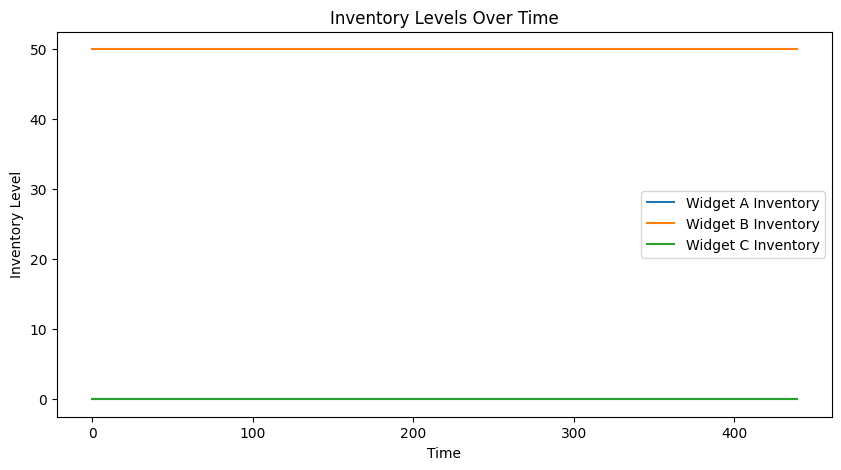

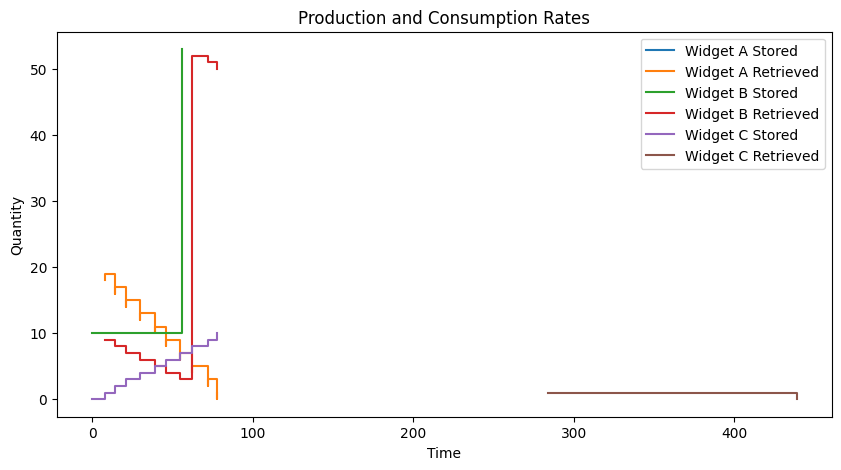

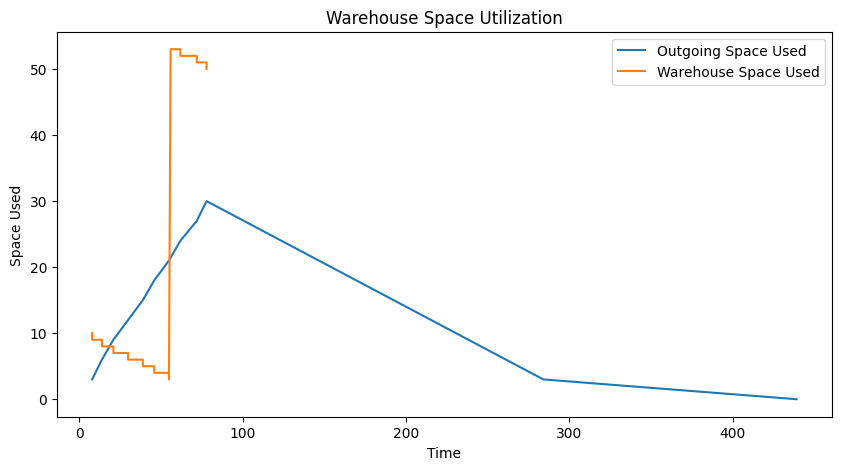

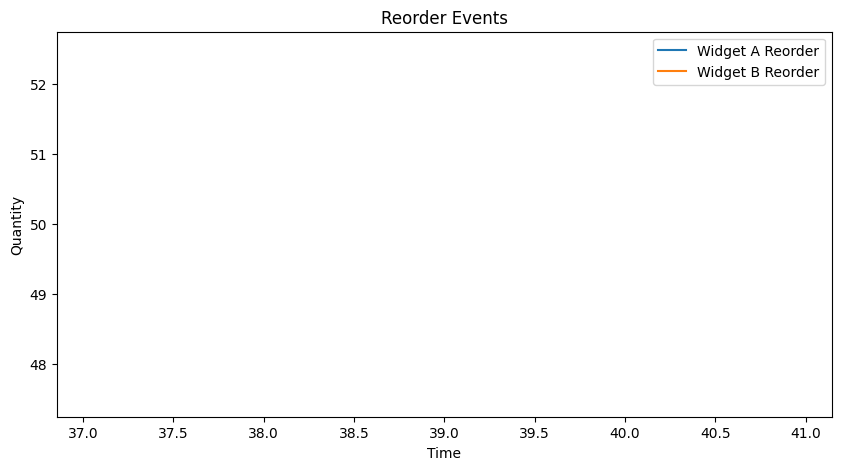

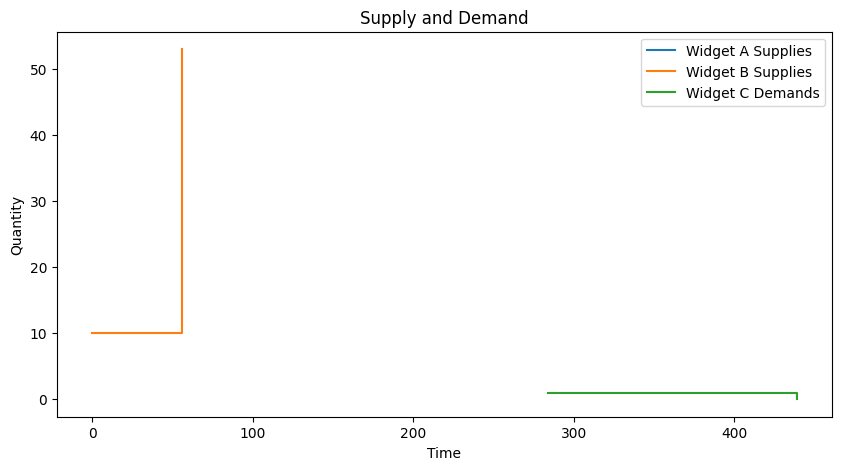

In [ ]:

# Visualization
def extract_data(log, action_type):
    return [(time, quantity) for time, action, quantity in log if action == action_type]

# Extract and sort data for each widget type
def extract_inventory(log, widget_type):
    edlwt1 = extract_data(log[widget_type], 'store')
    if (edlwt1 == []):
      time_store, quantity_store = [],[]
    else:
      time_store, quantity_store = zip(*sorted(edlwt1))
    edlwt2 = extract_data(log[widget_type], 'retrieve')
    if (edlwt2 == []):
      time_retrieve, quantity_retrieve = [],[]
    else:
      time_retrieve, quantity_retrieve = zip(*sorted(edlwt2))
    return time_store, quantity_store, time_retrieve, quantity_retrieve

time_a_store, quantity_a_store, time_a_retrieve, quantity_a_retrieve = extract_inventory(warehouseIn.log, 'Widget A')
time_b_store, quantity_b_store, time_b_retrieve, quantity_b_retrieve = extract_inventory(warehouseIn.log, 'Widget B')
time_c_store, quantity_c_store, time_c_retrieve, quantity_c_retrieve = extract_inventory(warehouseOut.log, 'Widget C')

# Inventory levels over time
time_points = sorted(set(time_a_store + time_a_retrieve + time_b_store + time_b_retrieve + time_c_store + time_c_retrieve))
inventory_a = [warehouseIn.inventory['Widget A'] if t <= env.now else None for t in time_points]
inventory_b = [warehouseIn.inventory['Widget B'] if t <= env.now else None for t in time_points]
inventory_c = [warehouseOut.inventory['Widget C'] if t <= env.now else None for t in time_points]

plt.figure(figsize=(10, 5))
plt.plot(time_points, inventory_a, label='Widget A Inventory')
plt.plot(time_points, inventory_b, label='Widget B Inventory')
plt.plot(time_points, inventory_c, label='Widget C Inventory')
plt.xlabel('Time')
plt.ylabel('Inventory Level')
plt.title('Inventory Levels Over Time')
plt.legend()
plt.show()

# Production and consumption rates
plt.figure(figsize=(10, 5))
plt.step(time_a_store, quantity_a_store, where='post', label='Widget A Stored')
plt.step(time_a_retrieve, quantity_a_retrieve, where='post', label='Widget A Retrieved')
plt.step(time_b_store, quantity_b_store, where='post', label='Widget B Stored')
plt.step(time_b_retrieve, quantity_b_retrieve, where='post', label='Widget B Retrieved')
plt.step(time_c_store, quantity_c_store, where='post', label='Widget C Stored')
plt.step(time_c_retrieve, quantity_c_retrieve, where='post', label='Widget C Retrieved')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Production and Consumption Rates')
plt.legend()
plt.show()

# Warehouse space utilization
time_spaceI, space_usedI = zip(*warehouseIn.log['space_used'])
time_spaceO, space_usedO = zip(*warehouseOut.log['space_used'])
time_spaceA, quantity_A = zip(*[(time, quantity) for time, action, quantity in warehouseIn.log['Widget A'] if (action == 'store' or action == 'retrieve')])
time_spaceB, quantity_B = zip(*[(time, quantity) for time, action, quantity in warehouseIn.log['Widget B'] if (action == 'store' or action == 'retrieve')])

plt.figure(figsize=(10, 5))
plt.plot(time_spaceO, space_usedO, label='Outgoing Space Used')
plt.plot(time_spaceI, space_usedI, label='Warehouse Space Used')
#plt.plot(time_spaceA, quantity_A, label='Quantity of A')
#plt.plot(time_spaceB, quantity_B, label='Quantity of B')
plt.xlabel('Time')
plt.ylabel('Space Used')
plt.title('Warehouse Space Utilization')
plt.legend()
plt.show()

# Supply and demand
def extract_reorder(log, widget_type):
    edlwt1 = extract_data(log[widget_type], 'reorder')
    if (edlwt1 == []):
      time_reorder, quantity_reorder = [],[]
    else:
      time_reorder, quantity_reorder = zip(*sorted(edlwt1))
    return time_reorder, quantity_reorder

time_a_reorder, quantity_a_reorder = extract_reorder(warehouseIn.log, 'Widget A')
time_b_reorder, quantity_b_reorder = extract_reorder(warehouseIn.log, 'Widget B')

plt.figure(figsize=(10, 5))
plt.step(time_a_reorder, quantity_a_reorder, where='post', label='Widget A Reorder')
plt.step(time_b_reorder, quantity_b_reorder, where='post', label='Widget B Reorder')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Reorder Events')
plt.legend()
plt.show()

# Combined supply and demand
plt.figure(figsize=(10, 5))
plt.step(time_a_store, quantity_a_store, where='post', label='Widget A Supplies')
plt.step(time_b_store, quantity_b_store, where='post', label='Widget B Supplies')
plt.step(time_c_retrieve, quantity_c_retrieve, where='post', label='Widget C Demands')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Supply and Demand')
plt.legend()
plt.show()


In [ ]:
# t,q = zip(*sorted(extract_data(warehouseIn.log['Widget A'], 'reorder')))
print([(time, quantity) for time, action, quantity in warehouseIn.log['Widget A'] if action == 'reorder'])



[]


- Separate the warehouses for incoming and outgoing
- Reorder level should be on the widget
- Keep troubleshooting the visualization